<h1>ENSEMBLE MODEL</h1>

In [13]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image

In [2]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Testing'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_generator.reset()

print('Data mounted successfully !!!')

Found 1212 images belonging to 4 classes.
Data mounted successfully !!!


In [3]:
densenet_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTech_Project/trained_models/DenseNet121_finetuned.keras')
inception_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTech_Project/trained_models/InceptionV3_finetuned.keras')
vgg_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTech_Project/trained_models/VGG16_finetuned.keras')

In [4]:
# Get predictions from each model
densenet_pred = densenet_model.predict(test_generator)
inception_pred = inception_model.predict(test_generator)
vgg_pred = vgg_model.predict(test_generator)

38/38 [==============================] - 264s 7s/step


In [5]:
# # Average the predictions (soft voting ensemble)
# ensemble_pred = (densenet_pred + inception_pred + vgg_pred) / 3.0

# # Convert averaged predictions to class labels
# ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

# # Get the true class labels
# y_true = test_generator.classes

In [6]:
# Sum the probability distributions (cumulative voting)
ensemble_pred = densenet_pred + inception_pred + vgg_pred

# Convert summed predictions to class labels (highest cumulative probability)
ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

# Get the true class labels
y_true = test_generator.classes

In [7]:
# Evaluate ensemble accuracy
ensemble_accuracy = np.sum(ensemble_pred_classes == y_true) / len(y_true)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

# Calculate the F1 score
f1 = f1_score(y_true, ensemble_pred_classes, average='weighted')
print(f"Ensemble F1 Score: {f1:.4f}")

# Classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, ensemble_pred_classes, target_names=class_labels))

Ensemble Test Accuracy: 0.9373
Ensemble F1 Score: 0.9370
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.87      0.91       252
  meningioma       0.89      0.90      0.90       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.90      1.00      0.95       249

    accuracy                           0.94      1212
   macro avg       0.94      0.93      0.93      1212
weighted avg       0.94      0.94      0.94      1212



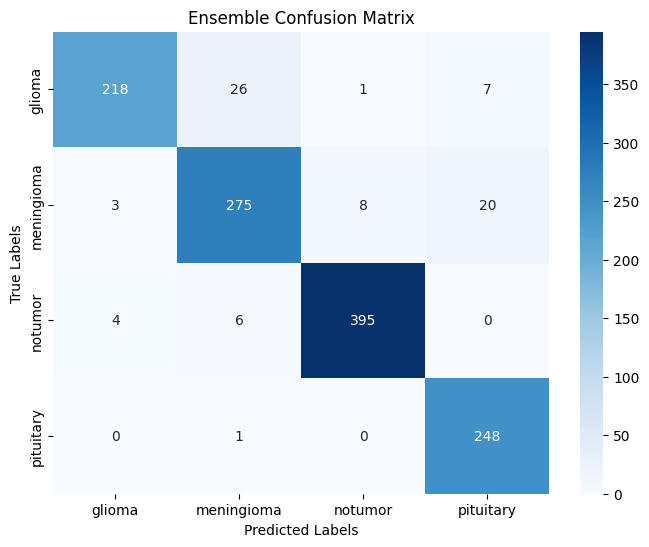

In [8]:
# Confusion matrix
cm = confusion_matrix(y_true, ensemble_pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [79]:
def preprocess_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

def predict_tumor_class(img_path):
    # Preprocess the image for each model
    densenet_img = preprocess_image(img_path, target_size=(224, 224))
    inception_img = preprocess_image(img_path, target_size=(299, 299))
    vgg_img = preprocess_image(img_path, target_size=(224, 224))

    # Get predictions from each model
    densenet_pred = densenet_model.predict(densenet_img)
    inception_pred = inception_model.predict(inception_img)
    vgg_pred = vgg_model.predict(vgg_img)

    # Average the predictions (soft voting ensemble)
    ensemble_pred = (densenet_pred + inception_pred + vgg_pred) / 3.0

    # Convert averaged predictions to class labels
    ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

    # Class mapping (update this based on your model's output)
    class_mapping = {0: 'glioma', 1: 'meningioma', 2: 'pituitary', 3: 'no tumor'}
    predicted_class = class_mapping[ensemble_pred_classes[0]]

    return predicted_class, ensemble_pred[0]

def get_bounding_box(mask):
    """Returns the bounding box coordinates from a binary mask."""
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Decrease the bounding box size slightly
        w = int(w * 0.7)  # Decrease width by 10%
        h = int(h * 0.7)  # Decrease height by 10%
#p
        # Recalculate x and y coordinates for the smaller bounding box
        x += int(0.5 * w)  # Shift x slightly to the right
        y += int(1 * h)  # Shift y slightly down

        # Return the bounding box coordinates (x1, y1, x2, y2)
        return (max(0, x), max(0, y),
                min(mask.shape[1], x + w),
                min(mask.shape[0], y + h))
    return None

def display_image_with_prediction(img_path, predicted_class):
    # Load the image
    img = Image.open(img_path)
    img_np = np.array(img)

    # For demonstration, create a dummy mask (you should replace this with your model's mask output)
    mask = np.zeros_like(img_np[:, :, 0])  # Create a binary mask of the same height and width
    mask[100:250, 100:300] = 1  # Dummy tumor area (this should be the output from your segmentation model)

    # Get bounding box from the mask
    bbox = get_bounding_box(mask)

    if bbox:
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox, outline="red", width=3)

    # Display the image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()

In [69]:
# def preprocess_image(img_path, target_size):
#     # Load the image
#     img = image.load_img(img_path, target_size=target_size)
#     img_array = image.img_to_array(img)  # Convert image to array
#     img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#     img_array /= 255.0  # Normalize the image
#     return img_array

# def predict_tumor_class(img_path):
#     # Preprocess the image for each model
#     densenet_img = preprocess_image(img_path, target_size=(224, 224))
#     inception_img = preprocess_image(img_path, target_size=(299, 299))
#     vgg_img = preprocess_image(img_path, target_size=(224, 224))

#     # Get predictions from each model
#     densenet_pred = densenet_model.predict(densenet_img)
#     inception_pred = inception_model.predict(inception_img)
#     vgg_pred = vgg_model.predict(vgg_img)

#     # Average the predictions (soft voting ensemble)
#     ensemble_pred = (densenet_pred + inception_pred + vgg_pred) / 3.0

#     # Convert averaged predictions to class labels
#     ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

#     # Class mapping (update this based on your model's output)
#     class_mapping = {0: 'glioma', 1: 'meningioma', 2: 'pituitary', 3: 'notumor'}
#     predicted_class = class_mapping[ensemble_pred_classes[0]]

#     return predicted_class, ensemble_pred[0]

# def get_bounding_box(mask):
#     """Returns the bounding box coordinates from a binary mask."""
#     # Find contours in the mask
#     contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if contours:
#         # Get the largest contour
#         largest_contour = max(contours, key=cv2.contourArea)
#         # Get bounding box coordinates
#         x, y, w, h = cv2.boundingRect(largest_contour)
#         # Return the bounding box coordinates (x1, y1, x2, y2)
#         return (x, y, x + w, y + h)
#     return None

# def display_image_with_prediction(img_path, predicted_class):
#     # Load the image
#     img = Image.open(img_path)
#     img_np = np.array(img)

#     # Create a dummy mask for demonstration
#     mask = np.zeros_like(img_np[:, :, 0])  # Create a binary mask of the same height and width
#     mask[100:250, 100:300] = 1  # Dummy tumor area (replace with segmentation output)

#     # Apply bounding box only for tumor classes
#     if predicted_class != "notumor":
#         bbox = get_bounding_box(mask)
#         if bbox:
#             draw = ImageDraw.Draw(img)
#             draw.rectangle(bbox, outline="red", width=3)

#     # Display the image with prediction
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Predicted Class: {predicted_class}')
#     plt.show()

1/1 [==============================] - 1s 546ms/step
Predicted Class: glioma
Probability Distributions: [9.9982828e-01 2.6988993e-05 6.9349473e-05 7.5418466e-05]



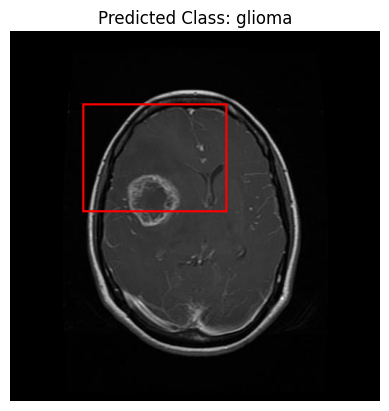

In [70]:
# Example usage
img_path = 'Te-gl_0014.jpg'  # Update with your image path
predicted_class, probabilities = predict_tumor_class(img_path)

print(f'Predicted Class: {predicted_class}')
print(f'Probability Distributions: {probabilities}')
print()

# Display the image with highlighted prediction
display_image_with_prediction(img_path, predicted_class)

1/1 [==============================] - 1s 639ms/step
Predicted Class: meningioma
Probability Distributions: [0.19999665 0.50193757 0.2161208  0.08194499]



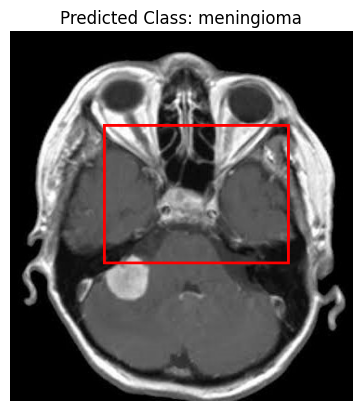

In [72]:
# Example usage
img_path = 'Te-me_0048.jpg'  # Update with your image path
predicted_class, probabilities = predict_tumor_class(img_path)

print(f'Predicted Class: {predicted_class}')
print(f'Probability Distributions: {probabilities}')
print()

# Display the image with highlighted prediction
display_image_with_prediction(img_path, predicted_class)

1/1 [==============================] - 1s 640ms/step
Predicted Class: notumor
Probability Distributions: [0.30591443 0.01361281 0.2552355  0.42523727]



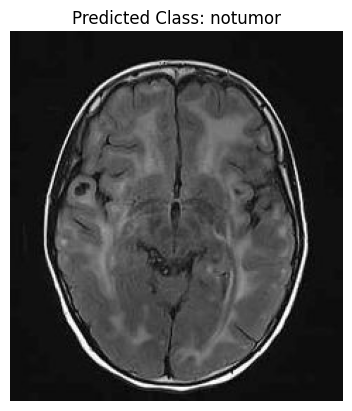

In [71]:
# Example usage
img_path = 'Te-no_0019.jpg'  # Update with your image path
predicted_class, probabilities = predict_tumor_class(img_path)

print(f'Predicted Class: {predicted_class}')
print(f'Probability Distributions: {probabilities}')
print()

# Display the image with highlighted prediction
display_image_with_prediction(img_path, predicted_class)

1/1 [==============================] - 1s 573ms/step
Predicted Class: no tumor
Probability Distributions: [0.10903258 0.00144998 0.00721801 0.8822994 ]



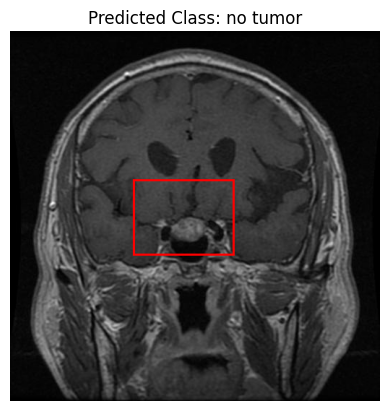

In [80]:
# Example usage
img_path = 'Te-pi_0045.jpg'  # Update with your image path
predicted_class, probabilities = predict_tumor_class(img_path)

print(f'Predicted Class: {predicted_class}')
print(f'Probability Distributions: {probabilities}')
print()

# Display the image with highlighted prediction
display_image_with_prediction(img_path, predicted_class)